# **Milestone 5: Advanced Model Development**

In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cleaned_df=pd.read_csv('cleaned_dynamic_pricing.csv')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_df.drop(columns=['Historical_Cost_of_Ride']),cleaned_df['Historical_Cost_of_Ride'],test_size=0.2, random_state=42)

In [4]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ord_loyalty', OrdinalEncoder(categories=[['Regular', 'Silver', 'Gold']]), ['Customer_Loyalty_Status']),
        ('ord_vehicle', OrdinalEncoder(categories=[['Economy', 'Premium']]), ['Vehicle_Type']),
        ('onehot', OneHotEncoder(sparse_output=False, drop='first', dtype=np.int32), ['Location_Category', 'Time_of_Booking']),
        ('scale', StandardScaler(), ['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides', 'Average_Ratings', 'Expected_Ride_Duration']) # Explicitly list numeric features to scale
    ],
    remainder='passthrough'
)


## **XGBoost**

In [5]:
# ---- Define model ----
trf5 = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.03,
    max_depth=7,
    random_state=42,
    verbosity=0
)

In [6]:

#pipeline combining preprocessing and model
pipe_XGB = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', trf5)
])

print("Consolidated preprocessor and pipeline created.")

Consolidated preprocessor and pipeline created.


In [7]:
# Use the consolidated pipeline
pipe_XGB.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord_loyalty',
                                                  OrdinalEncoder(categories=[['Regular',
                                                                              'Silver',
                                                                              'Gold']]),
                                                  ['Customer_Loyalty_Status']),
                                                 ('ord_vehicle',
                                                  OrdinalEncoder(categories=[['Economy',
                                                                              'Premium']]),
                                                  ['Vehicle_Type']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                dtype=<class 'numpy.int32'>,
                                                                sparse_output...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.03,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [8]:
y_pred_xgb = pipe_XGB.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae = mean_absolute_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Test RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

XGBoost Test RMSE: 77.1017, MAE: 56.3110, R2: 0.8370


In [9]:
param_grid = {
    'xgb__n_estimators': [100, 300, 400],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [3, 5, 7, 9],
    'xgb__gamma': [0, 0.1, 0.2]
}

In [10]:
grid_search = GridSearchCV(estimator=pipe_XGB, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

In [11]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord_loyalty',
                                                                         OrdinalEncoder(categories=[['Regular',
                                                                                                     'Silver',
                                                                                                     'Gold']]),
                                                                         ['Customer_Loyalty_Status']),
                                                                        ('ord_vehicle',
                                                                         OrdinalEncoder(categories=[['Economy',
                                                                                                     'Premium']]),
                                                                         ['Vehicle_Type']),
                                                                        ('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       dtype=<class...
                                                     max_depth=7,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=200,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             param_grid={'xgb__gamma': [0, 0.1, 0.2],
                         'xgb__learning_rate': [0.01, 0.05, 0.1],
                         'xgb__max_depth': [3, 5, 7, 9],
                         'xgb__n_estimators': [100, 300, 400]},
             scoring='neg_mean_squared_error')

In [12]:
best_model = grid_search.best_estimator_
y_pred_xgb_best = best_model.predict(X_test)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_xgb_best))
mae_best = mean_absolute_error(y_test, y_pred_xgb_best)
r2_best = r2_score(y_test, y_pred_xgb_best)

print(f"Best XGBoost Test RMSE: {rmse_best:.4f}")
print(f"Best XGBoost Test MAE: {mae_best:.4f}")
print(f"Best XGBoost Test R2: {r2_best:.4f}")

Best XGBoost Test RMSE: 69.9682
Best XGBoost Test MAE: 52.9351
Best XGBoost Test R2: 0.8657


 ## **LightGBM**

In [13]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [14]:
# ---- Define LightGBM model ----

lgbm_model = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.03,
    max_depth=7,
    random_state=42,
    verbosity=0
)

In [15]:
# Pipeline combining preprocessing and LightGBM model
pipe_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('lgbm', lgbm_model)
])

print("Consolidated preprocessor and LightGBM pipeline created.")

Consolidated preprocessor and LightGBM pipeline created.


In [16]:
pipe_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord_loyalty',
                                                  OrdinalEncoder(categories=[['Regular',
                                                                              'Silver',
                                                                              'Gold']]),
                                                  ['Customer_Loyalty_Status']),
                                                 ('ord_vehicle',
                                                  OrdinalEncoder(categories=[['Economy',
                                                                              'Premium']]),
                                                  ['Vehicle_Type']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                dtype=<class 'numpy.int32'>,
                                                                sparse_output=False),
                                                  ['Location_Category',
                                                   'Time_of_Booking']),
                                                 ('scale', StandardScaler(),
                                                  ['Number_of_Riders',
                                                   'Number_of_Drivers',
                                                   'Number_of_Past_Rides',
                                                   'Average_Ratings',
                                                   'Expected_Ride_Duration'])])),
                ('lgbm',
                 LGBMRegressor(learning_rate=0.03, max_depth=7,
                               n_estimators=200, random_state=42,
                               verbosity=0))])

In [17]:
# Defining the parameter grid for LightGBM
param_grid_lgbm = {
    'lgbm__n_estimators': [100,300],
    'lgbm__learning_rate': [0.01, 0.05, 0.1],
    'lgbm__max_depth': [3, 5, 7, 9],
    'lgbm__num_leaves': [31, 63, 127] 
}

# Setup GridSearchCV
grid_search_lgbm = GridSearchCV(estimator=pipe_lgbm, param_grid=param_grid_lgbm, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

print("GridSearchCV for LightGBM setup.")

GridSearchCV for LightGBM setup.


In [18]:
# Fit GridSearchCV to the training data
print("Starting LightGBM hyperparameter tuning...")
grid_search_lgbm.fit(X_train, y_train)
print("LightGBM hyperparameter tuning finished.")

# Get the best model
best_lgbm_model = grid_search_lgbm.best_estimator_

print(f"\nBest parameters found: {grid_search_lgbm.best_params_}")

# Evaluate the best model on the test set
y_pred_best_lgbm = best_lgbm_model.predict(X_test)

rmse_best_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_best_lgbm))
mae_best_lgbm = mean_absolute_error(y_test, y_pred_best_lgbm)
r2_best_lgbm = r2_score(y_test, y_pred_best_lgbm)

print(f"\nBest LightGBM Test RMSE: {rmse_best_lgbm:.4f}")
print(f"Best LightGBM Test MAE: {mae_best_lgbm:.4f}")
print(f"Best LightGBM Test R2: {r2_best_lgbm:.4f}")

Starting LightGBM hyperparameter tuning...
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

c:\Users\ASUS\anaconda3\envs\Dynamic-Pricing\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## **Back Testing**

In [26]:
def time_multiplier_map():
    return {
        "Morning": 1.10,
        "Afternoon": 1.00,
        "Evening": 1.10,
        "Night": 1.05
    }

def inventory_multiplier(riders, drivers):
    # Simple inventory-based pricing: increase when riders >> drivers, discount when drivers >>riders
    drivers = max(1, drivers)
    ratio = riders / drivers
    if ratio > 2.0:
        return 1.15
    if ratio > 1.5:
        return 1.10
    if ratio < 0.7:
        return 0.90
    return 1.00

def apply_rule_based_pricing(df, elasticity=-0.5):
    """
    elasticity: price elasticity of demand (negative). Example -0.5 means 10% price increase -> 5% drop in quantity.
    """
    tmap = time_multiplier_map()
    df = df.copy()
    # baseline assumptions
    df['base_price'] = df['Historical_Cost_of_Ride']
    df['base_qty'] = df['Number_of_Riders'].astype(float)
    # To compute multipliers and new price
    df['time_mult'] = df['Time_of_Booking'].map(tmap).fillna(1.0) # default 1.0 if missing
    df['inv_mult'] = df.apply(lambda r: inventory_multiplier(r['Number_of_Riders'], r['Number_of_Drivers']), axis=1)
    df['price_mult'] = df['time_mult'] * df['inv_mult']
    df['dyn_price'] = df['base_price'] * df['price_mult']
    #  new_qty = base_qty * (dyn_price / base_price) ** elasticity
    df['price_ratio'] = df['dyn_price'] / df['base_price'].replace(0, np.nan) # to avoid division by zero
    df['qty_mult'] = df['price_ratio'].fillna(1.0) ** elasticity
    df['dyn_qty'] = df['base_qty'] * df['qty_mult']
    # revenues
    df['base_revenue'] = df['base_price'] * df['base_qty']
    df['dyn_revenue'] = df['dyn_price'] * df['dyn_qty']
    # aggregate metrics
    total_base_rev = df['base_revenue'].sum()
    total_dyn_rev = df['dyn_revenue'].sum()
    revenue_lift_pct = ((total_dyn_rev - total_base_rev) / total_base_rev) * 100
    results = {
        'total_base_revenue': total_base_rev,
        'total_dynamic_revenue': total_dyn_rev,
        'revenue_lift_pct': revenue_lift_pct
    }
    return df, results

# Run the rule-based engine on the cleaned dataset
results_df, sim_metrics = apply_rule_based_pricing(cleaned_df, elasticity=-0.5)

print(f"Static total revenue: {sim_metrics['total_base_revenue']:.2f}")
print(f"Rule-based total revenue: {sim_metrics['total_dynamic_revenue']:.2f}")
print(f"Simulated revenue lift: {sim_metrics['revenue_lift_pct']:.2f}% (elasticity = -0.5)")

# Breakdown by Time_of_Booking to inspect where lift occurs
time_summary = results_df.groupby('Time_of_Booking')[['base_revenue', 'dyn_revenue']].sum()
time_summary['lift_pct'] = ((time_summary['dyn_revenue'] - time_summary['base_revenue']) / time_summary['base_revenue']) * 100
print("\nRevenue breakdown by Time_of_Booking:")
print(time_summary)

results_df.head()

Static total revenue: 22514545.02
Rule-based total revenue: 24408134.19
Simulated revenue lift: 8.41% (elasticity = -0.5)

Revenue breakdown by Time_of_Booking:
                 base_revenue   dyn_revenue   lift_pct
Time_of_Booking                                       
Afternoon        5.488150e+06  5.770574e+06   5.146068
Evening          5.203018e+06  5.750075e+06  10.514221
Morning          5.514224e+06  6.099820e+06  10.619745
Night            6.309153e+06  6.787665e+06   7.584408


,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,...,base_qty,time_mult,inv_mult,price_mult,dyn_price,price_ratio,qty_mult,dyn_qty,base_revenue,dyn_revenue
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273,...,90.0,1.05,1.10,1.155,328.317150,1.155,0.930484,83.743579,25583.154572,27494.453196
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753,...,58.0,1.10,1.00,1.100,191.262228,1.100,0.953463,55.300830,10084.735659,10576.959991
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469,...,42.0,1.00,1.00,1.000,329.795469,1.000,1.000000,42.000000,13851.409696,13851.409696
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232,...,89.0,1.00,1.15,1.150,540.731417,1.150,0.932505,82.992928,41847.909626,44876.883482
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422,...,78.0,1.00,1.15,1.150,666.633636,1.150,0.932505,72.735375,45215.150944,48487.847510



--- XGBoost Simulation with Elasticity = -0.9 ---
Static total revenue: 22514545.02
ML-based total revenue (XGBoost): 22497304.49
Simulated revenue lift (XGBoost): -0.08%

--- XGBoost Simulation with Elasticity = -0.5 ---
Static total revenue: 22514545.02
ML-based total revenue (XGBoost): 22478159.55
Simulated revenue lift (XGBoost): -0.16%

--- Comparison with Rule-based Engine (Elasticity = -0.5) ---
Rule-based total revenue: 24408134.19
Simulated revenue lift (Rule-based): 8.41%

XGBoost ML Predicted Price vs Historical Base Price Statistics:
       Historical_Cost_of_Ride  ml_price_xgb
count              1000.000000   1000.000000
mean                372.502623    373.307159
std                 187.158756    170.694992
min                  25.993449     59.430550
25%                 221.365202    227.659054
50%                 362.019426    382.084473
75%                 510.497504    510.372559
max                 836.116419    705.440247

Head of XGBoost ML Results DataFrame (usi

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,ml_price_xgb,base_price,base_qty,base_revenue,price_ratio_xgb,qty_mult_xgb,ml_qty_xgb,ml_revenue_xgb
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273,368.944519,284.257273,90.0,25583.154572,1.297925,0.877759,78.998305,29145.991480
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753,163.774582,173.874753,58.0,10084.735659,0.941911,1.030374,59.761709,9787.448863
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469,304.908905,329.795469,42.0,13851.409696,0.924539,1.040009,43.680397,13318.542070
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232,503.284637,470.201232,89.0,41847.909626,1.070360,0.966574,86.025073,43295.097784
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422,554.661194,579.681422,78.0,45215.150944,0.956838,1.022306,79.739848,44228.599221


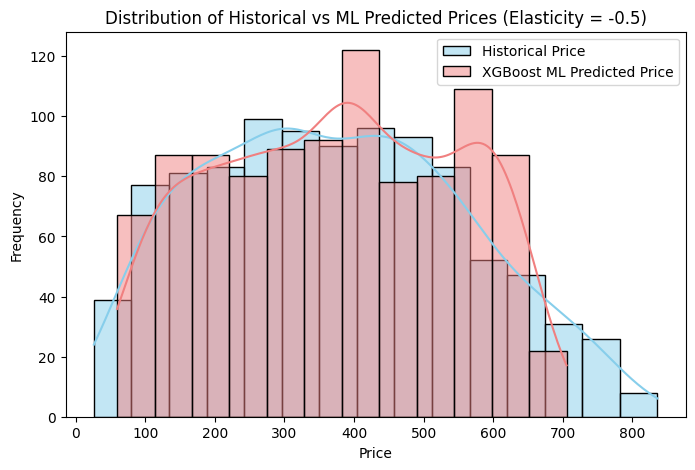

In [ ]:
# Backtesting with the trained XGBoost model
# We need to simulate the outcome of using the predicted price

def apply_ml_pricing_xgb(df, model, elasticity=-0.5):
    df = df.copy()

    # The model is trained on X_train (excluding 'Historical_Cost_of_Ride')
    # To ensure the input features to the model match the training features
    feature_cols = ['Number_of_Riders', 'Number_of_Drivers', 'Location_Category',
                    'Customer_Loyalty_Status', 'Number_of_Past_Rides', 'Average_Ratings',
                    'Time_of_Booking', 'Vehicle_Type', 'Expected_Ride_Duration']
    X_predict = df[feature_cols]

    # Apply preprocessing using the pipeline's preprocessor
    X_predict_transformed = model.named_steps['preprocessor'].transform(X_predict)

    # Predict using the trained XGBoost model
    df['ml_price_xgb'] = model.named_steps['xgb'].predict(X_predict_transformed)

    # Calculate baseline metrics
    df['base_price'] = df['Historical_Cost_of_Ride']
    df['base_qty'] = df['Number_of_Riders'].astype(float)
    df['base_revenue'] = df['base_price'] * df['base_qty']

    # Simulate new quantity based on price elasticity of demand
    # new_qty = base_qty * (ml_price / base_price) ** elasticity
    df['price_ratio_xgb'] = df['ml_price_xgb'] / df['base_price'].replace(0, np.nan) # avoid division by zero
    df['qty_mult_xgb'] = df['price_ratio_xgb'].fillna(1.0) ** elasticity
    df['ml_qty_xgb'] = df['base_qty'] * df['qty_mult_xgb']

    # Calculate dynamic revenue
    df['ml_revenue_xgb'] = df['ml_price_xgb'] * df['ml_qty_xgb']

    # Aggregate metrics
    total_base_rev = df['base_revenue'].sum()
    total_ml_rev_xgb = df['ml_revenue_xgb'].sum()
    revenue_lift_pct_xgb = ((total_ml_rev_xgb - total_base_rev) / total_base_rev) * 100

    results = {
        'total_base_revenue': total_base_rev,
        'total_ml_revenue_xgb': total_ml_rev_xgb,
        'revenue_lift_pct_xgb': revenue_lift_pct_xgb
    }
    return df, results

# Apply the ML-based pricing and evaluate using the XGBoost model with different elasticities
elasticity_values = [-0.9, -0.5] # Example: more elastic value and same as rule-based

for elasticity in elasticity_values:
    ml_results_df_xgb, ml_sim_metrics_xgb = apply_ml_pricing_xgb(cleaned_df, best_model, elasticity=elasticity)

    print(f"\n--- XGBoost Simulation with Elasticity = {elasticity} ---")
    print(f"Static total revenue: {ml_sim_metrics_xgb['total_base_revenue']:.2f}")
    print(f"ML-based total revenue (XGBoost): {ml_sim_metrics_xgb['total_ml_revenue_xgb']:.2f}")
    print(f"Simulated revenue lift (XGBoost): {ml_sim_metrics_xgb['revenue_lift_pct_xgb']:.2f}%")

# Compare with rule-based engine results (using the original elasticity for comparison)
print(f"\n--- Comparison with Rule-based Engine (Elasticity = -0.5) ---")
print(f"Rule-based total revenue: {sim_metrics['total_dynamic_revenue']:.2f}")
print(f"Simulated revenue lift (Rule-based): {sim_metrics['revenue_lift_pct']:.2f}%")


# Add analysis of predicted prices (using the last elasticity value from the loop)
print("\nXGBoost ML Predicted Price vs Historical Base Price Statistics:")
print(ml_results_df_xgb[['Historical_Cost_of_Ride', 'ml_price_xgb']].describe())

# Display head of the results dataframe (using the last elasticity value from the loop)
print("\nHead of XGBoost ML Results DataFrame (using last elasticity):")
display(ml_results_df_xgb.head())

# Add visualization to compare price distributions
plt.figure(figsize=(8, 5))
sns.histplot(ml_results_df_xgb['Historical_Cost_of_Ride'], color='skyblue', label='Historical Price', kde=True)
sns.histplot(ml_results_df_xgb['ml_price_xgb'], color='lightcoral', label='XGBoost ML Predicted Price', kde=True)
plt.title(f'Distribution of Historical vs ML Predicted Prices (Elasticity = {elasticity})') 
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

c:\Users\ASUS\anaconda3\envs\Dynamic-Pricing\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\Dynamic-Pricing\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\Dynamic-Pricing\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



--- Simulation with Elasticity = -0.9 ---
Static total revenue: 22514545.02
ML-based total revenue: 22510341.45
Simulated revenue lift (LGBM): -0.02%

--- Simulation with Elasticity = 0.0 ---
Static total revenue: 22514545.02
ML-based total revenue: 22616663.50
Simulated revenue lift (LGBM): 0.45%

--- Simulation with Elasticity = -0.5 ---
Static total revenue: 22514545.02
ML-based total revenue: 22525117.84
Simulated revenue lift (LGBM): 0.05%

--- Comparison with Rule-based Engine (Elasticity = -0.5) ---
Rule-based total revenue: 24408134.19
Simulated revenue lift (Rule-based): 8.41%

ML Predicted Price vs Historical Base Price Statistics:
       Historical_Cost_of_Ride     ml_price
count              1000.000000  1000.000000
mean                372.502623   373.886632
std                 187.158756   177.708014
min                  25.993449    43.344548
25%                 221.365202   228.914387
50%                 362.019426   378.181779
75%                 510.497504   519.1167

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,ml_price,base_price,base_qty,base_revenue,price_ratio,qty_mult,ml_qty,ml_revenue
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273,365.420606,284.257273,90.0,25583.154572,1.285528,0.881981,79.378298,29006.465941
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753,155.391627,173.874753,58.0,10084.735659,0.893699,1.057802,61.352526,9533.668865
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469,315.271886,329.795469,42.0,13851.409696,0.955962,1.022774,42.956512,13542.980565
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232,506.759372,470.201232,89.0,41847.909626,1.077750,0.963254,85.729639,43444.297854
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422,568.926501,579.681422,78.0,45215.150944,0.981447,1.009408,78.733800,44793.745277


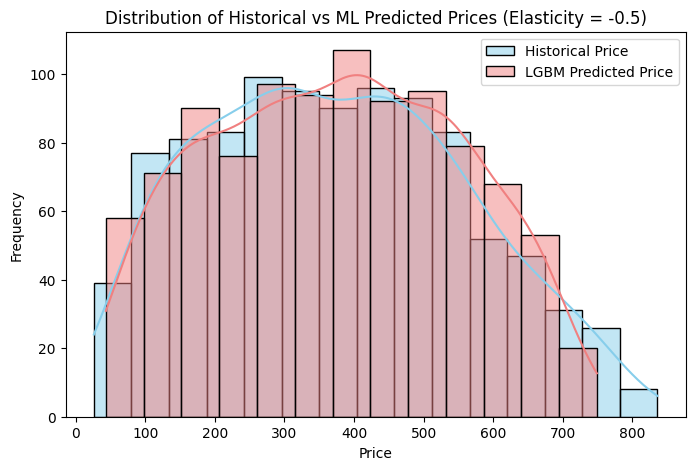

In [35]:
# Backtesting with the trained model
# We need to simulate the outcome of using the predicted price

def apply_ml_pricing(df, model, elasticity=-0.5):
    df = df.copy()

    # The model is trained on X_train (excluding 'Historical_Cost_of_Ride')
    # To ensure the input features to the model match the training features
    feature_cols = ['Number_of_Riders', 'Number_of_Drivers', 'Location_Category',
                    'Customer_Loyalty_Status', 'Number_of_Past_Rides', 'Average_Ratings',
                    'Time_of_Booking', 'Vehicle_Type', 'Expected_Ride_Duration']
    X_predict = df[feature_cols]

    # Apply preprocessing using the pipeline's preprocessor
    X_predict_transformed = model.named_steps['preprocessor'].transform(X_predict)

    # Predict using the trained LightGBM model
    df['ml_price'] = model.named_steps['lgbm'].predict(X_predict_transformed)

    # Calculate baseline metrics
    df['base_price'] = df['Historical_Cost_of_Ride']
    df['base_qty'] = df['Number_of_Riders'].astype(float)
    df['base_revenue'] = df['base_price'] * df['base_qty']

    # Simulate new quantity based on price elasticity of demand
    # new_qty = base_qty * (ml_price / base_price) ** elasticity
    df['price_ratio'] = df['ml_price'] / df['base_price'].replace(0, np.nan) # avoid division by zero
    df['qty_mult'] = df['price_ratio'].fillna(1.0) ** elasticity
    df['ml_qty'] = df['base_qty'] * df['qty_mult']

    # Calculate dynamic revenue
    df['ml_revenue'] = df['ml_price'] * df['ml_qty']

    # Aggregate metrics
    total_base_rev = df['base_revenue'].sum()
    total_ml_rev = df['ml_revenue'].sum()
    revenue_lift_pct = ((total_ml_rev - total_base_rev) / total_base_rev) * 100

    results = {
        'total_base_revenue': total_base_rev,
        'total_ml_revenue': total_ml_rev,
        'revenue_lift_pct': revenue_lift_pct
    }
    return df, results

# Apply the ML-based pricing and evaluate using the LightGBM model with different elasticities
elasticity_values = [-0.9, 0.0, -0.5] # Example: more elastic value, zero elasticity and same as rule-based

for elasticity in elasticity_values:
    ml_results_df, ml_sim_metrics = apply_ml_pricing(cleaned_df, pipe_lgbm, elasticity=elasticity)

    print(f"\n--- Simulation with Elasticity = {elasticity} ---")
    print(f"Static total revenue: {ml_sim_metrics['total_base_revenue']:.2f}")
    print(f"ML-based total revenue: {ml_sim_metrics['total_ml_revenue']:.2f}")
    print(f"Simulated revenue lift (LGBM): {ml_sim_metrics['revenue_lift_pct']:.2f}%")

# Compare with rule-based engine results (using the original elasticity for comparison)
print(f"\n--- Comparison with Rule-based Engine (Elasticity = -0.5) ---")
print(f"Rule-based total revenue: {sim_metrics['total_dynamic_revenue']:.2f}")
print(f"Simulated revenue lift (Rule-based): {sim_metrics['revenue_lift_pct']:.2f}%")


# Add analysis of predicted prices (using the last elasticity value from the loop)
print("\nML Predicted Price vs Historical Base Price Statistics:")
print(ml_results_df[['Historical_Cost_of_Ride', 'ml_price']].describe())

# Display head of the results dataframe (using the last elasticity value from the loop)
print("\nHead of ML Results DataFrame (using last elasticity):")
display(ml_results_df.head())

# Add visualization to compare price distributions
plt.figure(figsize=(8, 5))
sns.histplot(ml_results_df['Historical_Cost_of_Ride'], color='skyblue', label='Historical Price', kde=True)
sns.histplot(ml_results_df['ml_price'], color='lightcoral', label='LGBM Predicted Price', kde=True)
plt.title(f'Distribution of Historical vs ML Predicted Prices (Elasticity = {elasticity})') 
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()